### DATE: 1/3/2022
### Use Minard and Wind papers to estimate change in SNR from cooling solenoid and circuit.
### Minard and Wind papers part I and II
#### https://doi.org/10.1002/1099-0534(2001)13:2<128::AID-CMR1002>3.0.CO;2-8
####  https://doi.org/10.1002/cmr.1008
###
### Question 1: How does temperature effect Q of capacitors and the resistance of the circuit. 

In [118]:
# Imports:
from math import acos, ceil, cos, exp, floor, log10, pi, sin, sqrt, log
from operator import ior
import matplotlib
plt = matplotlib.pyplot
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp2d
# fonts
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 17}

matplotlib.rc('font', **font)

In [119]:
class Coil:

    def __init__(self, n, dcoil, lcoil, dwire, f, rho, alpha, beta, sigma,tc,ts):
        self.n = n
        self.dcoil = dcoil 
        self.lcoil = lcoil 
        self.dwire = dwire
        self.s = self.lcoil/self.n
        self.u0 = 4*pi*1e-7 # H/m vacuum permeability
        # self.rho = 1.72e-8 # (Cu) ohm meters 
        self.rho = rho
        self.ur = 1 # roughly for copper and siver
        self.f = f
        self.tc = tc # coil temp in Kelvin
        # sample stuff
        self.sigma = sigma # Siemans/m
        self.alpha = alpha # sample diameter
        self.beta = beta # sample length
        self.ts = ts # sample temp in Kelvin
    
    def Bxy(self):
        return self.n*self.u0 / (self.dcoil*sqrt(1+(self.lcoil/self.dcoil)**2))
    
    def Rcoil(self):
        # this changes with lcoil/dcoil
        # pick a value from the table for now
        # number of turns times the circumference...
        l = self.n*self.dcoil*pi
        rs = ((l/self.dwire)*sqrt(self.ur*self.u0*self.rho*self.f/pi))
        return rs*self.getEnhancementFactor()
          

    def Rleads(self):
        l = .005 # length of the leads 5mm
        d = self.dwire
        return (l/d) * sqrt(self.ur*self.u0*self.rho*self.f/pi) 

    def Rcap(self):
        #Q = 5.05*1e9*self.f**-2.35
        Q = 1000
        # calculate inductance
        # technically the leads also contribute inductance but i am ignoring it
        # correctors
        L = self.Lcoil()
        # need to estimate capacitance!
        Ctune = 1/(L*(2*pi*self.f)**2)
        return 1/(self.f*2*pi*Q*Ctune)

    def Lcoil(self):
        J = 2.33*log10(self.dwire/self.s) + .515
        K_v = [.01,.07,.15,.18,.21,.24,.25,.27,.28,.29,.3]
        if (self.n > 11):
            K = .3
        else:
            K = K_v[self.n-1]
        L = (9850*self.dcoil*self.n**2 / (4.5 + 10*(self.lcoil/self.dcoil))) \
             - 628*self.dcoil*self.n*(J+K)
        return L*1e-9

    def RsampleMagnetic(self):
        w = 2*pi*self.f
        return pi*w**2*self.u0**2*self.n**2*self.alpha**4*self.beta*self.sigma/(128*(self.dcoil**2 + self.beta**2))

    def RsampleDielectric(self):
        
        w = 2*pi*self.f
        #w = 2*pi*750e6
        Lcoil = self.Lcoil()
        #print('Lcoil (H): {}'.format(Lcoil))
        # eps
        enot = 8.85e-12 # F/m
        e0 = 78.32
        einf = 5.30
        tau = 8.27e-12
        epsPrime = einf + (e0 - einf)/(1+(w*tau)**2)
        epsDoublePrime = ((e0-einf)*w*tau)/(1+(w*tau)**2) + self.sigma/(w*enot)
        #print('first = {}'.format(((e0-einf)*w*tau)/(1+(w*tau)**2)))
        #print('second = {}'.format(self.sigma/(w*enot))) # correct
        
        #print('26.85 epsDoublePrime = {}'.format(epsDoublePrime))
        #print('78.32 epsPrime = {}'.format(epsPrime))
        eps = epsPrime - 1j*epsDoublePrime

        fd = .948 # in van heterens work he reports .25 for larger coils
        #itestfd = self.dcoil*log(self.dcoil/self.alpha)/(2*self.lcoil) + 1
        #testfd = 1/itestfd
        #print('.78 fd: {}'.format(testfd))
        
        H = .1126*self.lcoil/self.dcoil + .08 + (.27/((self.lcoil/self.dcoil)**.5))
        Cstray = 100*H*self.dcoil* 1e-12 # change to Farads
        #print('Cstray = {}'.format(Cstray))
        Cprime = .5*Cstray
        
        C1 = Cprime*(1/(1-fd)) # equation 23
        oldC1 = pi*enot*self.dcoil/(2*log(self.dcoil/self.alpha))
        #print('C1 = {}'.format(C1))
        #print('oldC1 = {}'.format(oldC1))
        C2 = epsPrime*Cprime*(1/fd) # equation 23
        oldC2 = epsPrime*enot*pi*self.alpha**2/(4*self.lcoil)
        
        #print('C2 = {}'.format(C2))
        #print('oldC2 = {}'.format(oldC2))
        
        Rd = epsPrime/(w*C2*epsDoublePrime)
        
        Yreal = (Rd*(w*C1)**2)/(1+(((C1+C2)**2)*((w*Rd)**2))) # equation 20
        
        Re = Yreal * Lcoil**2 * w**2 # equation 19

        return Re 
        #return 60*self.RsampleMagnetic()



    def Rnmr(self):
        #return (self.Rcoil() + self.Rcap() + self.Rleads() + self.RsampleMagnetic())
        return (self.Rcoil() + self.RsampleMagnetic() + self.RsampleDielectric() + self.Rcap() + self.Rleads())
    def RnmrTemp(self):
        #return (self.Rcoil() + self.Rcap() + self.Rleads() + self.RsampleMagnetic())
        return ((self.Rcoil() + self.Rcap() + self.Rleads())*self.tc + (self.RsampleMagnetic() + self.RsampleDielectric())*self.ts)
    
    def getEnhancementFactor(self):
        dos = self.dwire/(self.s)
        coil_ratio = self.lcoil/self.dcoil
        crs = [0.0,  0.2,  0.4,  0.6,  0.8,  1.0,  2.0,  4.0,  6.0,  8.0, 10.0, 1000000] # 12 the jth index
        dss = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
        dss = [el for el in reversed(dss)]
        # ----------------------------------------
        # linear interpolate between the values
        ef_table = np.matrix('5.31, 5.45, 5.65, 5.80, 5.80, 5.55, 4.10, 3.54, 3.31, 3.20, 3.23, 3.41;\
            3.73, 3.84, 3.99, 4.11, 4.17, 4.10, 3.36, 3.05, 2.92, 2.90, 2.93, 3.11;\
                2.74, 2.83, 2.97, 3.10, 3.20, 3.17, 2.74, 2.60, 2.60, 2.62, 2.65, 2.81;\
                    2.12, 2.20, 2.28, 2.38, 2.44, 2.47, 2.32, 2.27, 2.29, 2.34, 2.37, 2.51;\
                        1.74, 1.77, 1.83, 1.89, 1.92, 1.94, 1.98, 2.01, 2.03, 2.08, 2.10, 2.22;\
                            1.44, 1.48, 1.54, 1.60, 1.64, 1.67, 1.74, 1.78, 1.80, 1.81, 1.83, 1.93;\
                                1.26, 1.29, 1.33, 1.38, 1.42, 1.45, 1.50, 1.54, 1.56, 1.57, 1.58, 1.65;\
                                    1.16, 1.19, 1.21, 1.22, 1.23, 1.24, 1.28, 1.32, 1.34, 1.34, 1.35, 1.40;\
                                        1.07, 1.08, 1.08, 1.10, 1.10, 1.10, 1.13, 1.15, 1.16, 1.16, 1.17, 1.19;\
                                            1.02, 1.02, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 1.04, 1.04, 1.04, 1.05')
        # get the values and do a 2d linear interpolation:
        # ef(y,x) or crs,dss
        ef = interp2d(crs,dss,ef_table, kind='linear')
        e = ef(coil_ratio,dos)
        # correction, equation 11
        en = 1 + (e-1)*(1-1/self.n)
        return en

    def getSig(self):
        return (self.Bxy()*(2*pi*self.f)**2)/sqrt(self.Rnmr())
    
    def getSNR(self):
        return (self.Bxy()*(2*pi*self.f)**2)/sqrt(self.RnmrTemp())
    
    def displayResistance(self):
        # Rcoil, Rleads, Rcap, RsampleMagnetic, RsampleDielectric
        print('Rcoil (Ω): {}\n'.format(self.Rcoil()))
        print('Rleads (Ω): {}\n'.format(self.Rleads()))
        print('Rcap (Ω): {}\n'.format(self.Rcap()))
        print('RsampleMagnetic (Ω): {}\n'.format(self.RsampleMagnetic()))
        print('RsampleDielectric (Ω): {}\n'.format(self.RsampleDielectric()))

c:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


(0.0, 60.0)

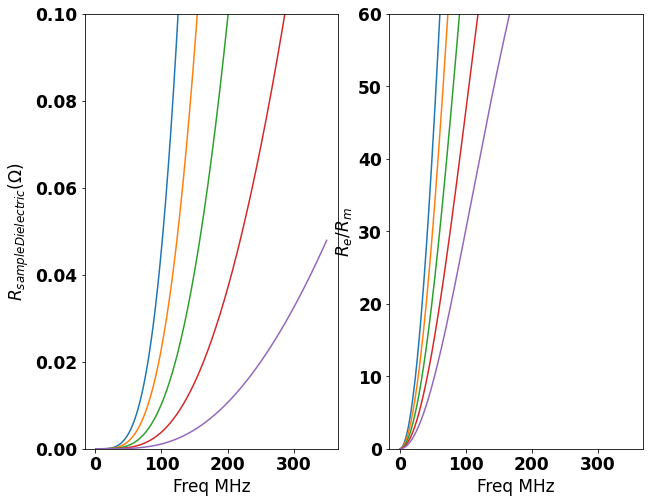

In [120]:
ts = 293
tc = 293
rho_c = 1.68e-8 # room temp
sigma = 1
# coil sizes:
nump = 1000
dcoil = .00114
lcoil = .00216
dwire = .000110
# sample size
alpha = .00113 # sample diameter
beta = 5*lcoil # sample length

# recreate figure 8 in part II
fs = np.linspace(0,350e6,350)

rsd_12 = []
rsd_10 = []
rsd_8 = []
rsd_6 = []
rsd_4 = []
rr12 = []
rr10 = []
rr8 = []
rr6 = []
rr4 = []
for fi in range(350):
    # sample size 1:
    #     Coil(n, dcoil, lcoil, dwire, f, rho, alpha, beta, sigma, tc, ts)
    c = Coil(12, dcoil, lcoil, dwire, fs[fi], rho_c, alpha, beta, sigma, tc, ts)
    rsd_12.append(c.RsampleDielectric())
    rr12.append(c.RsampleDielectric()/c.RsampleMagnetic())
    c = Coil(10, dcoil, lcoil, dwire, fs[fi], rho_c, alpha, beta, sigma, tc, ts)
    rsd_10.append(c.RsampleDielectric())
    rr10.append(c.RsampleDielectric()/c.RsampleMagnetic())
    c = Coil(8, dcoil, lcoil, dwire, fs[fi], rho_c, alpha, beta, sigma, tc, ts)
    rsd_8.append(c.RsampleDielectric())
    rr8.append(c.RsampleDielectric()/c.RsampleMagnetic())
    c = Coil(6, dcoil, lcoil, dwire, fs[fi], rho_c, alpha, beta, sigma, tc, ts)
    rsd_6.append(c.RsampleDielectric())
    rr6.append(c.RsampleDielectric()/c.RsampleMagnetic())
    c = Coil(4, dcoil, lcoil, dwire, fs[fi], rho_c, alpha, beta, sigma, tc, ts)
    rsd_4.append(c.RsampleDielectric())
    rr4.append(c.RsampleDielectric()/c.RsampleMagnetic())
    
# figure 8 and 9, Re is being overestimated
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(fs*1e-6,rsd_12)
plt.plot(fs*1e-6,rsd_10)
plt.plot(fs*1e-6,rsd_8)
plt.plot(fs*1e-6,rsd_6)
plt.plot(fs*1e-6,rsd_4)
plt.xlabel('Freq MHz')
plt.ylabel(r'$R_{sampleDielectric} (Ω)$')
plt.ylim(0,.1)
plt.subplot(1,2,2)
plt.plot(fs*1e-6,rr12)
plt.plot(fs*1e-6,rr10)
plt.plot(fs*1e-6,rr8)
plt.plot(fs*1e-6,rr6)
plt.plot(fs*1e-6,rr4)
plt.xlabel('Freq MHz')
plt.ylabel(r'$R_{e}/R_{m}$')
plt.ylim(0,60)

In [90]:
# test the above:
# something is wrong with sample dielectric resistance, way too high
rho_s = 1 # ohm m, .5 S/m conductivity
sigma = 1/rho_s
f0 = 650e6
n = 6 # surface loop for now

ts = 293
tsCold = 273.7

# coil sizes:
nump = 1000
dcoil = .00114
lcoil = .00216
dwire = .000110
# sample size
alpha = .0008 # sample diameter
beta = 5*lcoil # sample length

# temperature stuff
rho_c = 1.68e-8 # room temp
tc = 293
rho_cCold = 1.8e-9 #
tcCold = 70

cse = Coil(n, dcoil, lcoil, dwire, f0, rho_c, alpha, beta, sigma, tc, ts)

cse.displayResistance()
#Using the  ratio of mea-sured  values  forC1  andC2  already  quoted,
# andtaking to be 78.32, an experimental value of 0.78 is determined forfusing the expressions
#try 21?

Rcoil (Ω): [0.5062472]

Rleads (Ω): 0.09499891256445912

Rcap (Ω): 0.07821351800243398

RsampleMagnetic (Ω): 0.0008729163636002837

RsampleDielectric (Ω): 0.7209449480734895



In [135]:
# Coil(n, dcoil, lcoil, dwire, f, rho, alpha, beta, sigma, tc, ts)


# Gather DATA!
# Show how SNR varies with coil size, at two temps. with fixed sample radii (10 cm , 1cm, 1mm)
I = 1
# z depends on sample size always center of sample
rho_s = 2 # ohm m, .5 S/m conductivity
sigma = 1/rho_s

f0 = 650e6
n = 6 # surface loop for now
dwire = .0004
ts = 293
tsCold = 273.7

# coil sizes:
nump = 1000
dcoilSizes = np.linspace(.0005, .01, nump) # .5mm -> 10 mm coil size
lcoilSizes = 1.2*dcoilSizes
# sample size
alphas = .8*dcoilSizes # sample diameter
betas = 5*lcoilSizes # sample length

# temperature stuff
rho_c = 1.68e-8 # room temp
tc = 293

rho_cCold = 1.8e-9 #
tcCold = 70

snr1_rt = []
snr1_ct = []
#snr2_rt = []
#snr2_ct = []
#snr3_rt = []
#snr3_ct = []

for di in range(nump):
    # sample size 1:
    #     Coil(n, dcoil, lcoil, dwire, f, rho, alpha, beta, sigma, tc, ts)
    cse = Coil(n, dcoilSizes[di], lcoilSizes[di], dwire, f0, rho_c, alphas[di], betas[di], sigma, tc, ts)
    snr1_rt.append(cse.getSNR())
    
    cse = Coil(n, dcoilSizes[di], lcoilSizes[di], dwire, f0, rho_cCold, alphas[di], betas[di], sigma, tcCold, tsCold)
    snr1_ct.append(cse.getSNR())
    # sample size 2:
    #cse = coil_sample_experiment(di,I,z[1],b[1],rho_s,f0,n,rho_c,wd,ts,tc)
    #snr2_rt.append(cse.SNR())
    #cse = coil_sample_experiment(di,I,z[1],b[1],rho_s,f0,n,rho_cCold,wd,tsCold,tcCold)
    #snr2_ct.append(cse.SNR())
    # sample size 3:
    #cse = coil_sample_experiment(di,I,z[2],b[2],rho_s,f0,n,rho_c,wd,ts,tc)
    #snr3_rt.append(cse.SNR())
    #cse = coil_sample_experiment(di,I,z[2],b[2],rho_s,f0,n,rho_cCold,wd,tsCold,tcCold)
    #snr3_ct.append(cse.SNR())


(0.0, 3.0)

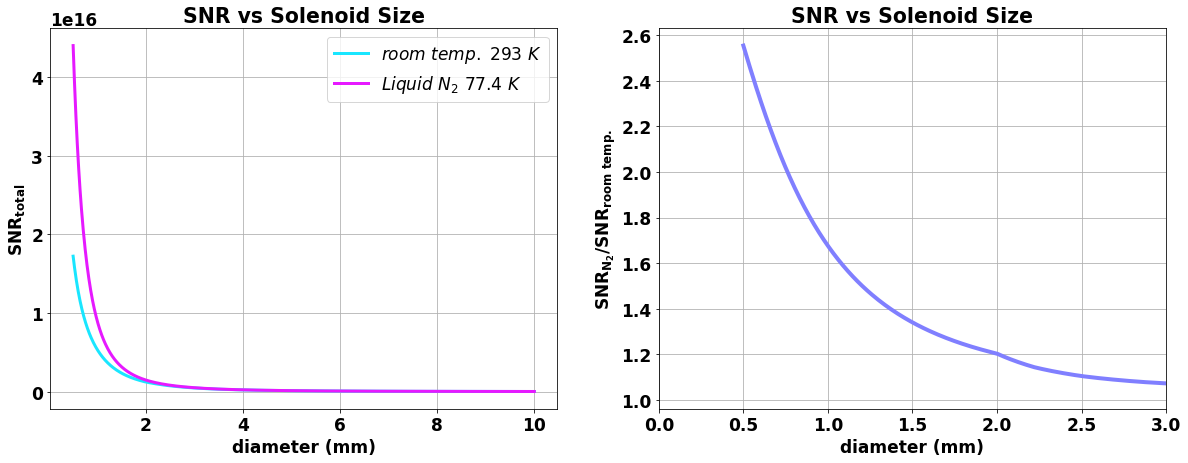

In [137]:
# plot it now:
col = plt.cm.cool([0.1,0.9,.5]) 
plt.subplots(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(dcoilSizes*1000, snr1_rt,linewidth=3,label=r'$room\ temp.\ 293\ K$',color=col[0])
plt.plot(dcoilSizes*1000, snr1_ct,linewidth=3,label=r'$Liquid\ N_2\ 77.4\ K$',color=col[1])

plt.xlabel('diameter (mm)',fontweight='bold')
plt.ylabel(r'$\bfSNR_{total}$',fontweight='bold')
plt.title('SNR vs Solenoid Size',fontweight='bold')
plt.grid()
legend_properties = {'weight':'normal'}

plt.legend(prop=legend_properties)

plt.subplot(1,2,2)
plt.plot(dcoilSizes*1000, np.divide(snr1_ct,snr1_rt),linewidth=4,color=col[2])
plt.grid()
plt.xlabel('diameter (mm)',fontweight='bold')
plt.ylabel(r'$\bfSNR_{N_2}/SNR_{room\ temp.}$',fontweight='bold')
plt.title('SNR vs Solenoid Size',fontweight='bold')
plt.xlim(0,3)